# Extract some data for HydroTas deliverables

In [85]:
import glob

import dask

dask.config.set(**{"array.slicing.split_large_chunks": False})

import numpy as np

import xarray as xr

from functools import reduce

In [60]:
from distributed import Client
from dask_jobqueue import PBSCluster

walltime = "02:00:00"
cores = 48
memory = "192GB"
cluster = PBSCluster(
    processes=1,
    walltime=str(walltime),
    cores=cores,
    memory=str(memory),
    job_extra=[
        "-q express",
        "-l ncpus=" + str(cores),
        "-l mem=" + str(memory),
        "-P xv83",
        "-l jobfs=100GB",
        "-l storage=gdata/xv83+gdata/oi10",
    ],
    local_directory="$PBS_JOBFS",
    header_skip=["select"],
)

cluster.scale(jobs=1)
client = Client(cluster)
print(f"Dask daskboard link: {client.dashboard_link}")

/g/data/xv83/users/ds0092/software/miniconda3/envs/pangeo/lib/python3.9/site-packages/distributed/node.py:160: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 38197 instead
  warnings.warn(


Dask daskboard link: http://10.6.61.33:38197/status


In [108]:
def open_zarr_forecasts(
    files,
    convert_time_to_lead=True,
    preprocess=None,
    time_dim="time",
    init_dim="init",
    lead_dim="lead",
    **open_kwargs
):
    """Open and stack zarr forecasts"""

    def composite_function(*func):
        def compose(f, g):
            return lambda x: f(g(x))

        return reduce(compose, func, lambda x: x)

    def convert_time_to_lead(ds):
        init_date = ds[time_dim][0].item()
        time_freq = xr.infer_freq(ds[time_dim])
        lead_time = range(len(ds[time_dim]))
        time_coord = (
            ds[time_dim]
            .rename({time_dim: lead_dim})
            .assign_coords({lead_dim: lead_time})
            .expand_dims({init_dim: [init_date]})
        ).compute()
        dataset = ds.rename({time_dim: lead_dim}).assign_coords(
            {lead_dim: lead_time, init_dim: [init_date]}
        )
        dataset = dataset.assign_coords({time_dim: time_coord})
        dataset[lead_dim].attrs["units"] = time_freq
        return dataset

    if convert_time_to_lead:
        preprocess = composite_function(preprocess, convert_time_to_lead)

    return xr.open_mfdataset(
        files,
        compat="override",
        preprocess=preprocess,
        engine="zarr",
        coords="minimal",
        parallel=True,
    )

In [74]:
data_dir = "/g/data/xv83/dcfp/CAFE-f6"

In [109]:
def truncate_latitudes(ds, dp=10, lat_dim="lat"):
    for dim in ds.dims:
        if "lat" in dim:
            ds = ds.assign_coords({dim: ds[dim].round(decimals=dp)})
    return ds


realm = "atmos_hybrid_daily.zarr.zip"
variables = ["t_surf", "precip", "latb", "lonb"]
files = sorted(glob.glob(f"{data_dir}/c5-d60-pX-f6-????11??*/{realm}"))[-16:]

data_global = open_zarr_forecasts(files, preprocess=truncate_latitudes)[variables].drop(
    ["average_DT", "average_T1", "average_T2"]
)

/g/data/xv83/users/ds0092/software/miniconda3/envs/pangeo/lib/python3.9/site-packages/dask/array/core.py:4454: PerformanceWarning: Increasing number of chunks by factor of 24
  result = blockwise(
/g/data/xv83/users/ds0092/software/miniconda3/envs/pangeo/lib/python3.9/site-packages/dask/array/core.py:4454: PerformanceWarning: Increasing number of chunks by factor of 25
  result = blockwise(
/g/data/xv83/users/ds0092/software/miniconda3/envs/pangeo/lib/python3.9/site-packages/dask/array/core.py:4454: PerformanceWarning: Increasing number of chunks by factor of 24
  result = blockwise(
/g/data/xv83/users/ds0092/software/miniconda3/envs/pangeo/lib/python3.9/site-packages/dask/array/core.py:4454: PerformanceWarning: Increasing number of chunks by factor of 24
  result = blockwise(
/g/data/xv83/users/ds0092/software/miniconda3/envs/pangeo/lib/python3.9/site-packages/dask/array/core.py:4454: PerformanceWarning: Increasing number of chunks by factor of 24
  result = blockwise(
/g/data/xv83/us

In [112]:
data_global

<xarray.Dataset>
Dimensions:   (init: 16, lead: 3653, ensemble: 96, lat: 90, lon: 144, latb: 91, lonb: 145)
Coordinates:
  * latb      (latb) float64 -90.0 -88.99 -86.97 -84.94 ... 86.97 88.99 90.0
  * lonb      (lonb) float64 0.0 2.5 5.0 7.5 10.0 ... 352.5 355.0 357.5 360.0
  * lead      (lead) int64 0 1 2 3 4 5 6 ... 3646 3647 3648 3649 3650 3651 3652
    area      (lat, lon) float32 dask.array<chunksize=(90, 144), meta=np.ndarray>
  * ensemble  (ensemble) int64 1 2 3 4 5 6 7 8 9 ... 88 89 90 91 92 93 94 95 96
  * lat       (lat) float64 -89.49 -87.98 -85.96 -83.93 ... 85.96 87.98 89.49
  * lon       (lon) float64 1.25 3.75 6.25 8.75 ... 351.2 353.8 356.2 358.8
    zsurf     (lat, lon) float32 dask.array<chunksize=(90, 144), meta=np.ndarray>
  * init      (init) object 2005-11-01 12:00:00 ... 2020-11-01 12:00:00
    time      (init, lead) object 2005-11-01 12:00:00 ... nan
Data variables:
    t_surf    (init, lead, ensemble, lat, lon) float32 dask.array<chunksize=(1, 28, 96, 90, 144), meta=np.ndarray>
    precip    (init, lead, ensemble, lat, lon) float32 dask.array<chunksize=(1, 28, 96, 90, 144), meta=np.ndarray>
Attributes:
    filename:   atmos_hybrid_daily.zarr
    grid_tile:  N/A
    grid_type:  regular
    title:      AccessOcean-AM2

In [113]:
def extract_lon_lat_box(ds, box, lon_dim="lon", lat_dim="lat"):
    """
    Get a region definied by a lat lon box. Note this version of this function only
    works for regular grids
    """
    # Force longitudues to range from 0-360
    ds = ds.assign_coords({lon_dim: (ds[lon_dim] + 360) % 360})

    # Allow for regions that cross 360 deg
    if box[0] > box[1]:
        lon_logic_func = np.logical_or
    else:
        lon_logic_func = np.logical_and
    lon_inds = np.where(
        lon_logic_func(ds[lon_dim].values >= box[0], ds[lon_dim].values <= box[1])
    )[0]
    lat_inds = np.where(
        np.logical_and(ds[lat_dim].values >= box[2], ds[lat_dim].values <= box[3])
    )[0]
    return ds.isel({lon_dim: lon_inds, lat_dim: lat_inds})

In [123]:
data_Tas = extract_lon_lat_box(data_global, [142, 150, -45, -38]).isel(lead=slice(3652))

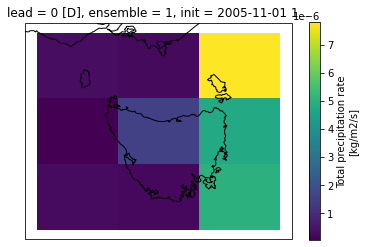

In [124]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

import cartopy

cartopy.config["pre_existing_data_dir"] = "/g/data/xv83/users/ds0092/data/cartopy-data"
cartopy.config["data_dir"] = "/g/data/xv83/users/ds0092/data/cartopy-data"

ax = plt.axes(projection=ccrs.PlateCarree(180))
data_Tas.isel(lead=0, ensemble=0, init=0)["precip"].plot(
    ax=ax, transform=ccrs.PlateCarree()
)
ax.coastlines()

In [125]:
data_Tas.to_netcdf("daily_CAFEf6_hindcast_20051101-20201101_gn.nc")

In [ ]:
cluster.close()
client.close()